# Fairness Evaluation of UserKNN on the MovieLens 100K Dataset

**Course:** System Development for Marketing  
**Assignment:** Hyperpersonalization – Recommender Systems  
**Model Focus:** Item-based Collaborative Filtering (ItemKNN)  
**Dataset:** MovieLens 100K  
**Author:** Lucas van der Wielen  
**Date:** 04-04-2025

## Introduction

This notebook presents the implementation and evaluation of an Item-based K-Nearest Neighbors (ItemKNN) recommender system using the MovieLens 100K dataset. ItemKNN is a memory-based collaborative filtering technique that generates recommendations for a user based on items similar to those the user has rated positively.

The objectives of this notebook are twofold:

1. **Performance Evaluation**: Train and tune the ItemKNN model and assess its accuracy using RMSE (Root Mean Squared Error).
2. **Prepare a Dataset for Fairness Evaluation**: Create a general dataset to use for fairness evaluation across the different models

Gender is selected as the primary protected attribute to allow for consistent comparison across datasets, including Yelp, which lacks age-related data. Throughout this notebook, we follow a reproducible pipeline that includes data preprocessing, model training, prediction, and evaluation using both accuracy-based and fairness-based metrics.

## Datasets needed for this Jupyter Notebook:

- `df_full.csv`  
  Preprocessed dataset combining ratings and user/item metadata.

### Importing Libraries and Packages
In this section, we import the necessary libraries and packages that will be used throughout the code for data manipulation, model building, and evaluation.

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Define the path to your CSV file
file_path = r"C:\Users\LucasvanderWielenAlp\OneDrive - Alpine Hearing Protection\Documenten\Master DDB\System Development\Data\df_full.csv"

# Load the CSV file into a DataFrame
df_full = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to check
print(df_full.head())
print(df_full.shape)

   movie_id  user_id  rating            timestamp  age gender  occupation  \
0       242      196       3  1997-12-04 15:55:49   49      M      writer   
1       302      186       3  1998-04-04 19:22:22   39      F   executive   
2       377       22       1  1997-11-07 07:18:36   25      M      writer   
3        51      244       2  1997-11-27 05:02:03   28      M  technician   
4       346      166       1  1998-02-02 05:33:16   47      M    educator   

  zip_code                       title release_date  release_year  
0    55105                Kolya (1996)  24-Jan-1997          1997  
1    00000    L.A. Confidential (1997)  01-Jan-1997          1997  
2    40206         Heavyweights (1994)  01-Jan-1994          1994  
3    80525  Legends of the Fall (1994)  01-Jan-1994          1994  
4    55113         Jackie Brown (1997)  01-Jan-1997          1997  
(99991, 11)


In [3]:
# Create the full user-item matrix
user_item_matrix = df_full.pivot_table(index='user_id', columns='movie_id', values='rating')

# Create empty train/test matrices
train_matrix = user_item_matrix.copy() * np.nan
test_matrix = user_item_matrix.copy() * np.nan

# User-wise split: 80% train, 20% test
for user_id in user_item_matrix.index:
    user_ratings = user_item_matrix.loc[user_id].dropna()
    if len(user_ratings) < 5:
        continue
    shuffled = user_ratings.sample(frac=1, random_state=42)
    cutoff = int(0.8 * len(shuffled))
    train_items = shuffled.iloc[:cutoff]
    test_items = shuffled.iloc[cutoff:]

    train_matrix.loc[user_id, train_items.index] = train_items.values
    test_matrix.loc[user_id, test_items.index] = test_items.values

# Convert train/test matrices back to long-format DataFrames
df_train = train_matrix.stack().reset_index()
df_train.columns = ['user_id', 'movie_id', 'rating']

df_test = test_matrix.stack().reset_index()
df_test.columns = ['user_id', 'movie_id', 'rating']

# Print stats: check user/movie coverage
print("Train users:", df_train['user_id'].nunique())
print("Test users: ", df_test['user_id'].nunique())
print("Train movies:", df_train['movie_id'].nunique())
print("Test movies: ", df_test['movie_id'].nunique())

Train users: 943
Test users:  943
Train movies: 1617
Test movies:  1480


In [4]:
# DOUBLE CHECK – Rating count and overlap validation
# Rebuild full matrix from df_full
full_matrix = df_full.pivot_table(index='user_id', columns='movie_id', values='rating')

# Rebuild train/test matrices from df_train and df_test
train_matrix_check = full_matrix.copy() * np.nan
test_matrix_check = full_matrix.copy() * np.nan

for _, row in df_train.iterrows():
    train_matrix_check.loc[row['user_id'], row['movie_id']] = row['rating']

for _, row in df_test.iterrows():
    test_matrix_check.loc[row['user_id'], row['movie_id']] = row['rating']

# Validate counts and overlap
original_count = (~full_matrix.isna()).sum().sum()
train_count = (~train_matrix_check.isna()).sum().sum()
test_count = (~test_matrix_check.isna()).sum().sum()
overlap_matrix = (~train_matrix_check.isna()) & (~test_matrix_check.isna())
overlap_count = overlap_matrix.sum().sum()

print("\nDOUBLE CHECK:")
print(f"Original rating count: {original_count}")
print(f"Train rating count:    {train_count}")
print(f"Test rating count:     {test_count}")
print(f"Total (train + test):  {train_count + test_count}")
print("Rating count preserved:", original_count == train_count + test_count)
print(f"Overlapping ratings in train and test: {overlap_count}")
print("No overlap between train and test:", overlap_count == 0)


DOUBLE CHECK:
Original rating count: 99991
Train rating count:    79610
Test rating count:     20381
Total (train + test):  99991
Rating count preserved: True
Overlapping ratings in train and test: 0
No overlap between train and test: True


In [5]:
# Build item-item similarity matrix from df_train
train_pivot = df_train.pivot_table(index='user_id', columns='movie_id', values='rating')
item_matrix = train_pivot.T.fillna(0)  # Transpose to get item-item structure

# Cosine similarity between items
item_similarity = cosine_similarity(item_matrix)
item_similarity_df = pd.DataFrame(item_similarity, index=item_matrix.index, columns=item_matrix.index)

In [6]:
# Define prediction function for ItemKNN
def predict_rating_itemknn(user_id, movie_id, k):
    if movie_id not in item_similarity_df.columns or user_id not in train_pivot.index:
        return np.nan

    user_ratings = train_pivot.loc[user_id].dropna()
    if len(user_ratings) == 0:
        return np.nan

    sims = item_similarity_df.loc[movie_id, user_ratings.index]
    top_k = sims.sort_values(ascending=False).head(k)
    top_k_ratings = user_ratings[top_k.index]

    if top_k.sum() == 0:
        return np.nan

    return np.dot(top_k, top_k_ratings) / top_k.sum()

# Hyperparameter tuning for k (top-k neighbors)

k_values = [5, 10, 15, 20, 30, 50]
results = []

for k in k_values:
    actual, predicted = [], []

    for _, row in df_test.iterrows():
        pred = predict_rating_itemknn(row['user_id'], row['movie_id'], k)
        if not np.isnan(pred):
            actual.append(row['rating'])
            predicted.append(pred)

    if predicted:
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        results.append((k, rmse))
        print(f"k={k}, RMSE={rmse:.4f}")
    else:
        print(f"k={k}, No predictions made.")

# Final test with best k
best_k, best_rmse = min(results, key=lambda x: x[1])
print(f"\nBest k: {best_k} with RMSE: {best_rmse:.4f}")

# Final predictions using best_k
final_actual, final_predicted = [], []

for _, row in df_test.iterrows():
    pred = predict_rating_itemknn(row['user_id'], row['movie_id'], best_k)
    if not np.isnan(pred):
        final_actual.append(row['rating'])
        final_predicted.append(pred)

final_rmse = np.sqrt(mean_squared_error(final_actual, final_predicted))
print(f"\nFinal RMSE using best k={best_k}: {final_rmse:.4f}")

k=5, RMSE=0.9951
k=10, RMSE=0.9748
k=15, RMSE=0.9738
k=20, RMSE=0.9765
k=30, RMSE=0.9830
k=50, RMSE=0.9926

Best k: 15 with RMSE: 0.9738

Final RMSE using best k=15: 0.9738


In [9]:
# Create prediction DataFrame for ItemKNN using best_k
itemknn_preds_df = df_test.copy()
itemknn_preds_df['predicted_rating'] = [
    predict_rating_itemknn(row['user_id'], row['movie_id'], best_k)
    for _, row in df_test.iterrows()
]
itemknn_preds_df = itemknn_preds_df.dropna(subset=['predicted_rating'])

# Rename columns for consistency
itemknn_preds_df = itemknn_preds_df.rename(columns={
    'rating': 'true_rating',
    'predicted_rating': 'est'
})

RMSE for male users (ItemKNN):   0.9634
RMSE for female users (ItemKNN): 1.0031


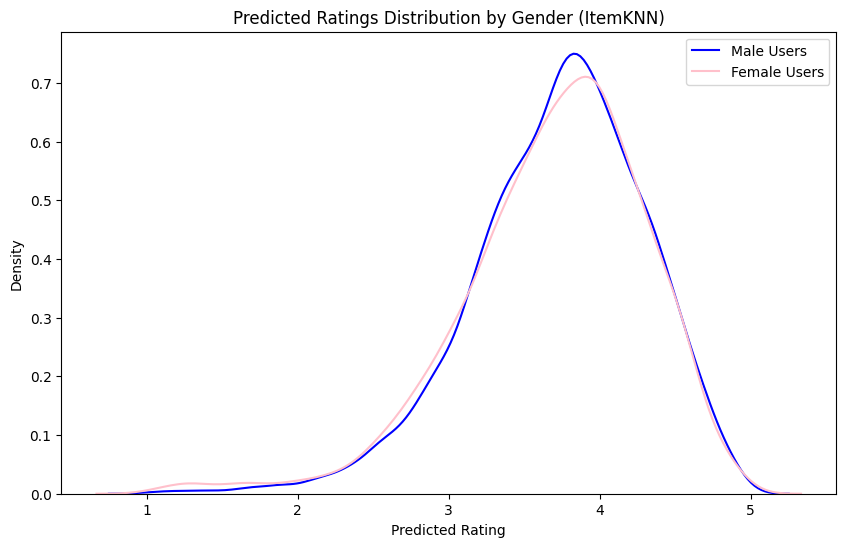

In [11]:
# Merge with gender information
df_gender_comparison = df_full[['user_id', 'gender']].drop_duplicates()
itemknn_gender_df = pd.merge(itemknn_preds_df, df_gender_comparison, on='user_id', how='inner')

# Filter and compute RMSE for each gender
male_preds = itemknn_gender_df[itemknn_gender_df['gender'] == 'M']
female_preds = itemknn_gender_df[itemknn_gender_df['gender'] == 'F']

male_rmse = ((male_preds['true_rating'] - male_preds['est'])**2).mean() ** 0.5
female_rmse = ((female_preds['true_rating'] - female_preds['est'])**2).mean() ** 0.5

print(f"RMSE for male users (ItemKNN):   {male_rmse:.4f}")
print(f"RMSE for female users (ItemKNN): {female_rmse:.4f}")

plt.figure(figsize=(10, 6))
sns.kdeplot(male_preds['est'], label='Male Users', color='blue')
sns.kdeplot(female_preds['est'], label='Female Users', color='pink')
plt.title("Predicted Ratings Distribution by Gender (ItemKNN)")
plt.xlabel("Predicted Rating")
plt.ylabel("Density")
plt.legend()
plt.show()

In [7]:
# Create an empty list to collect prediction rows
itemknn_preds = []

# Loop through the test set and collect predictions
for _, row in df_test.iterrows():
    user = row['user_id']
    movie = row['movie_id']
    actual = row['rating']
    
    pred = predict_rating_itemknn(user, movie, best_k)
    
    if not np.isnan(pred):
        itemknn_preds.append({
            'user_id': user,
            'movie_id': movie,
            'actual_rating': actual,
            'predicted_rating': pred,
            'model': 'itemknn'
        })

# Convert to DataFrame
df_itemknn_preds = pd.DataFrame(itemknn_preds)

# Quick check
print(df_itemknn_preds.head())
print(f"\nTotal predictions made by ItemKNN: {len(df_itemknn_preds)}")

# saved and used for fairness metrics

   user_id  movie_id  actual_rating  predicted_rating    model
0      1.0       9.0            5.0          3.941185  itemknn
1      1.0      14.0            5.0          4.465212  itemknn
2      1.0      15.0            5.0          3.818630  itemknn
3      1.0      18.0            4.0          3.921278  itemknn
4      1.0      21.0            1.0          3.796338  itemknn

Total predictions made by ItemKNN: 20303
